# Reprojection

In this notebook, we'll learn how to reproject [Cloud Optimized GeoTIFFs](https://www.cogeo.org/) into a new [Coordinate Reference System](https://gdal.org/tutorials/osr_api_tut.html). There are several options for reprojecting. Which is best depends on whether you know your destination CRS while loading the data and whether you have STAC items for your data.

* [Option 1](Reproject-while-loading-with-stackstac.stack): **Reproject a large number of COGs *while loading*** using [stackstac](https://stackstac.readthedocs.io/en/latest/). This method requires STAC items, which are available for all the remote-sensing datasets in the Planetary Computer's data catalog.
* [Option 2](Reproject-while-loading-with-rioxarray-and-rasterio-using-a-WarpedVRT): **Reproject a single COG *while loading*** with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a [WarpedVRT](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). This method works without STAC items, but won't scale to a large number of COGs.
* [Option 3](Reproject-an-in-memory-array-with-stackstac.reproject_array): **Reproject an *in-memory* (potentially distributed) DataArray** with [`stackstac.reproject_array`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html). This requires more memory and is generally less efficient than option 1, but doesn't require knowing the destination CRS while loading the data.
* [Option 4](Reproject-an-in-memory-DataArray-with-rioxarray-and-rasterio): **Reproject an *in-memory* (single machine) DataArray** using [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html). This only works on a single machine and requires more memory than option 2, but doesn't require knowing the descition CRS while loading the data.

These options are ranked in the recommended order, though certain options may not be available for your use case. Reprojecting *while loading* the data (options 1 and 2) has a lower memory footprint than reprojecting data that is already in memory. So if you know what CRS you want while loading the data, you should do the reprojection while loading. And if you have STAC items available, you should use them, with `stackstac` to do the loading. Note that options 1, 2 and 4 use *GDAL* internally while option 3 uses `xarray.DataArray.interp` instead.

In [1]:
import planetary_computer as pc
import pystac

import numpy as np
import xarray as xr

import stackstac
import affine
import pyproj
import rioxarray
import rasterio

from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

## Local Dask Cluster

We use a small dataset so let's create a local Dask Cluster.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at that address to follow the progress of your computation.

The region of interest in this section is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. 
This example uses [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. See [Reading data from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for more.

In [3]:
item_id = "S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE"
item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    f"sentinel-2-l2a/items/{item_id}"
)
item = pc.sign_assets(item)
item.properties["proj:epsg"]

32613

## Reproject while loading with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

The selected scene is stored in `EPSG:32613` coordinate system. Let's reproject it to a new CRS by providing the destination `epsg` number to the function [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html), which uses [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) internally. In this example, we reproject to the Lambert Cylindrical projection (`epsg:6933`). Lambert Cylindrical is an equal area projection, a map projection that preserves area measure. Regions with the same size on the Earth have the same size on the map but generally distort the shape, angle, and scale.

In [4]:
scene_data = (
    stackstac.stack(
        [item.to_dict()],
        epsg=6933,
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        resolution=100,
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

<xarray.DataArray 'stackstac-707b6d0704080a261a95a31bb90bf692' (band: 3, y: 995, x: 1235)>
dask.array<getitem, shape=(3, 995, 1235), dtype=float64, chunksize=(1, 995, 1235), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U65 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
  * x                                        (x) float64 -1.035e+07 ... -1.02...
  * y                                        (y) float64 4.591e+06 ... 4.491e+06
    s2:high_proba_clouds_percentage          float64 0.01433
    ...                                       ...
    proj:transform                           object {0.0, 300000.0, 10.0, 430...
    gsd                                      int64 10
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-10353400, 4491300, -10229900,...
    crs:         epsg:6933
    transform:   | 100.00, 0.00,-10353400.00|\n| 0.00,-100.00, 4590800.00|\n|...
    resolution:  100

With [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html) function, we can create a true color image to see how the data looks like. Inputs of the function are the 3 bands of `red`, `green`, `blue`, 2 optional numeric params `c`, `th` for contrast and brightness enhancement. You can also set name for output image by providing a value for `name` to the function.

We will use the same combination of `c` and `th` for all images in this tutorial.

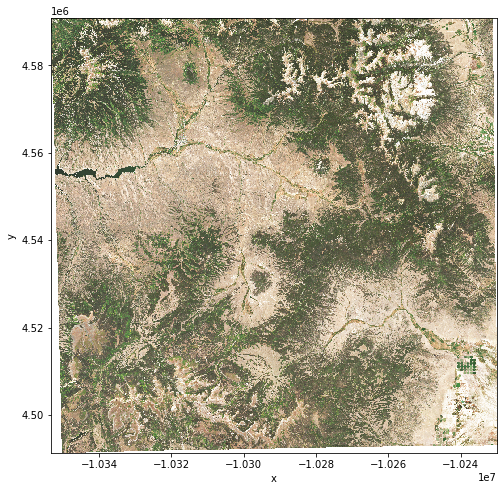

In [5]:
# visualize selected scene
cylindrical_img = ms.true_color(*scene_data, c=30, th=0.05, name="epsg=6933")
cylindrical_img.plot.imshow(figsize=(8, 8));

## Reproject while loading with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a `WarpedVRT`

`WarpedVRT` does not require prior download of GeoTIFF files, we provide the URLs directly as the inputs. In following script, we fetch data from the Microsoft Sentinel-2 Azure Blob Storage and reproject them from their source CRS of `EPSG:32613` to the Robinson CRS of `ESRI:54030`.

In [6]:
urls = {
    "red": item.assets["B04"].href,
    "green": item.assets["B03"].href,
    "blue": item.assets["B02"].href,
}

#### Robinson (ESRI:54030)

The Robinson projection is a map projection of a world map that does not preserve equal-area nor conformal. Both the lines of altitude and longitude are evenly spaced across the map for a compromise.

In this example, we use `ESRI:54030` as the target/destination CRS and demonstrate how to normalize a stack of images against a regular grid in a defined bounding box with following steps:
- Get rasterio CRS for `ESRI:54030` (Note that in case you want to reproject to an `EPSG` CRS, e.g: EPSG:4326, simply put its number, 4326, as the destination CRS.)
- Define a shape (height, width), and bounding box (coords) for the target reprojected/destination image.
- Calculate transform to reproject from source CRS to destination CRS.
- Provide all above information to `WarpedVRT`, including: destination CRS, destination shape, and destination transform.
- Finally, do the projection.

In [7]:
robinson_crs = pyproj.crs.CRS.from_string("ESRI:54030")
robinson_crs = rasterio.crs.CRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

In [8]:
height = width = 1000
robinson_bounds = (-9438051, 4153437, -9285636, 4046189)

# calculate destination transform
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

In [9]:
robinson_vrt_options = {
    "crs": robinson_crs,
    "transform": robinson_transform,
    "height": height,
    "width": width,
}

In [10]:
robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 1000, "y": 1000, "band": 1}
            )
            robinson_reproj.append(reproj)

robinson_reproj = xr.concat(robinson_reproj, dim="band")

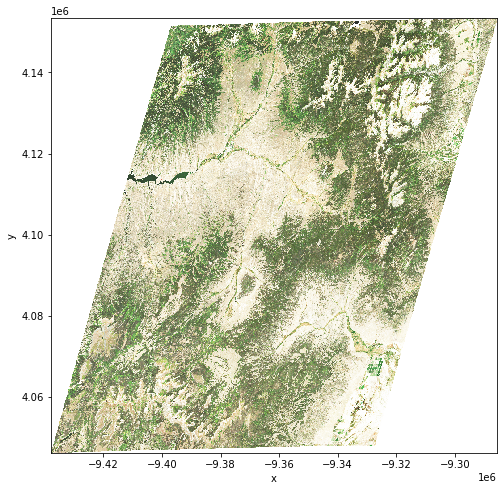

In [11]:
# visualize
robinson_img = ms.true_color(
    *robinson_reproj,
    c=30,
    th=0.05,
    name="esri=54030",
)
robinson_img.plot.imshow(figsize=(8, 8));

## Reproject an in-memory array with [stackstac.reproject_array](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html)

`stackstac` provides a tool called `reproject_array` that uses [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html) internally to reproject and clip a `xarray.DataArray` to a new destination CRS. No GDAL dependency required. `reproject_array` takes a DataArray as input data, we'll use the scene data created from the beginning to do experiments in this section.

#### Space Oblique (EPSG: 29873)

Space Oblique is a projection especially designed for satellite imagery so that it is completely free of distortion along the orbit path of the satellite.

In [12]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(scene_data, space_oblique_crs)

space_oblique_spec = stackstac.raster_spec.RasterSpec(
    epsg=space_oblique_crs, bounds=space_oblique_bounds, resolutions_xy=(100, 100)
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10675077.084681889, 9757187.124107027, 10823668.536491105, 9906913.424226366), resolutions_xy=(100, 100))

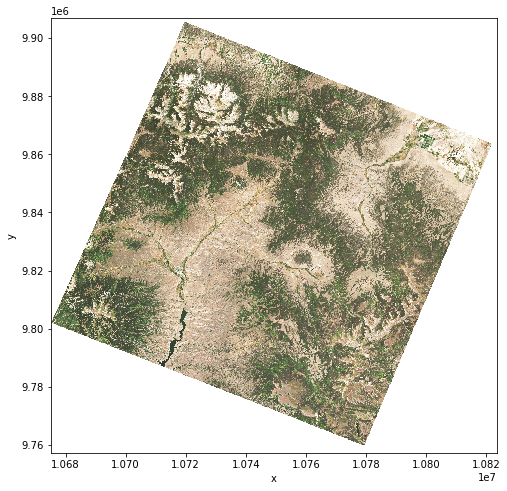

In [13]:
space_oblique_reproj = stackstac.reproject_array(scene_data, space_oblique_spec)

space_oblique_img = ms.true_color(
    *space_oblique_reproj, c=30, th=0.05, name="epsg=29873"
)
space_oblique_img.plot.imshow(figsize=(8, 8));

## Reproject an in-memory DataArray with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)

[rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) provide tools for raster warping and reprojection that uses GDAL under the hood.

#### Web Mercator (EPSG:3857)

Web Mercator, the standard for Web mapping applications, is a variant of the Mercator projection. Its usage spans widely over major online map providers. In the below, we reproject our scene data from the CRS of `EPSG:6933` to Web Mercator CRS of `EPSG:3857` with [rioxarray](https://corteva.github.io/rioxarray/stable/)

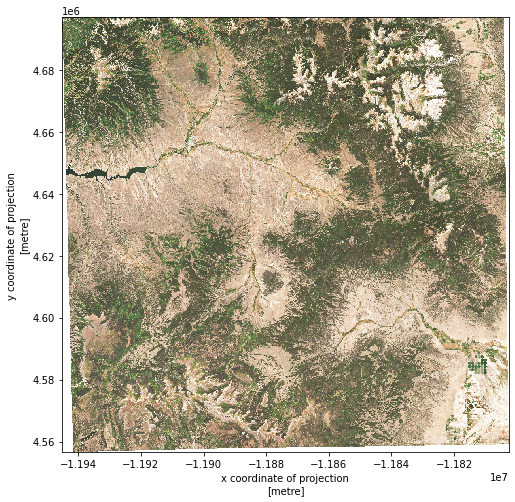

In [14]:
web_mecator_crs = 3857

web_mecator_reproj = scene_data.rio.reproject(web_mecator_crs)
web_mecator_img = ms.true_color(*web_mecator_reproj, c=30, th=0.05, name="epsg=3857")

web_mecator_img.plot.imshow(figsize=(8, 8));

#### WGS84 projection - lat/lon (equirectangular) projection (EPSG:4326)
This very common one displays meridians and parallels as equally spaced vertical and horizontal lines. Conversion between x, y coordinates on the map and earth locations are very simple, and this is a very popular one for general use. However, the significant distortions inherent to this method make it impractical for many scientific application. Let's see how our data looks in this crs by reprojecting it with [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject) with following steps:

- Get shape, CRS, bounds and transform information from the source dataset.
- Define destination CRS.
- Calculate the shape, transform and coords of the destination.
- Reproject the source data to destination CRS and reconstruct the result.

In [15]:
# source information
src_crs = {"init": scene_data.crs}
src_bounds = scene_data.rio.bounds()
src_transform = scene_data.transform
bands, src_height, src_width = scene_data.shape

# destination CRS
WGS84_crs = {"init": "EPSG:4326"}

# calculate destination transform
WGS84_transform, WGS84_width, WGS84_height = rasterio.warp.calculate_default_transform(
    src_crs, WGS84_crs, src_width, src_height, *src_bounds
)
# array to write results to
WGS84_data = np.zeros((bands, WGS84_height, WGS84_width))

WGS84_transform, WGS84_width, WGS84_height

(Affine(0.0010199914261785408, 0.0, -107.30489322500127,
        0.0, -0.0010199914261785408, 38.827024319904964),
 1255,
 970)

In [16]:
# coords of the destination
WGS84_coords = _make_coords(
    scene_data, WGS84_transform, WGS84_width, WGS84_height, WGS84_crs
)

WGS84_xs = WGS84_coords["x"]
WGS84_ys = WGS84_coords["y"]

In [17]:
rasterio.warp.reproject(
    scene_data,
    WGS84_data,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=WGS84_transform,
    dst_crs=WGS84_crs,
)

# reconstruct result as an xarray DataArray
WGS84_reproj = xr.DataArray(
    WGS84_data,
    dims=["band", "y", "x"],
    coords={"band": scene_data.band, "y": WGS84_ys, "x": WGS84_xs},
)

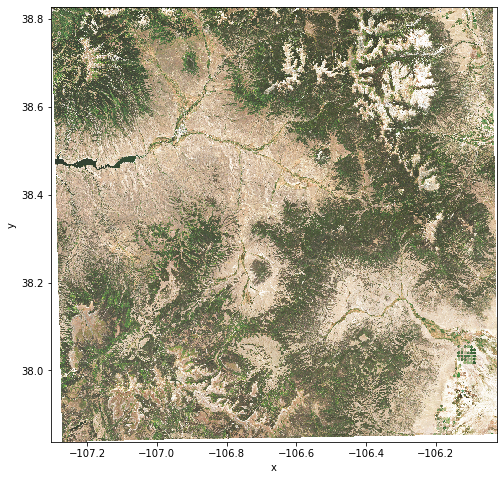

In [18]:
WGS84_img = ms.true_color(*WGS84_reproj, c=30, th=0.05, name="epsg=4326")
WGS84_img.plot.imshow(figsize=(8, 8));

### Show results

Let's plot all images and put them side by side to have an overview of what we have done so far.

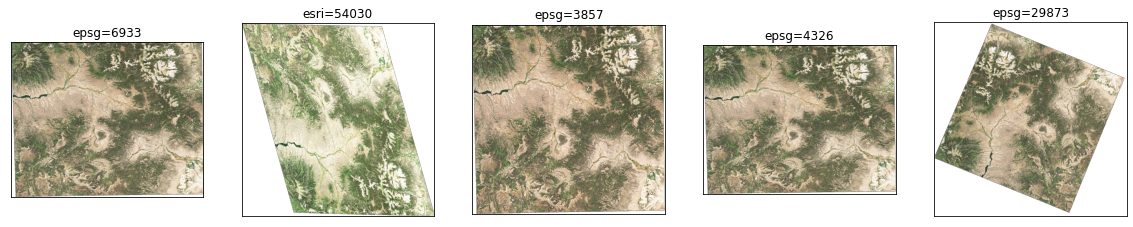

In [19]:
imgs = [cylindrical_img, robinson_img, web_mecator_img, WGS84_img, space_oblique_img]

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(20, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i].data)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(imgs[i].name)

plt.show()